# Deterministic Model 02: Model parameters

In [1]:
# install libraries
#%pip install pandas
#%pip install numpy

In [2]:
# import pandas library
import pandas as pd
import numpy as np

### Read Data

In [3]:
# Read the file and assign it to variable "df_real"
other_path = '../../data/sim/merged_data.csv'
df = pd.read_csv(other_path, header=0)

In [4]:
# show the first 5 rows using dataframe.head() method
print('The first 5 rows of the dataframe')
df.head(5)

The first 5 rows of the dataframe


,id,type_brick,type,rotation,x,y,z,layer,pallet,dist,start_to_verif,verif_to_dest,dest_to_end,total_time
0,1,CORNER,2,90,220,95,0,1,1,2630,6,18,16,40
1,2,HALF,3,90,220,252,0,1,1,2305,4,16,18,38
2,4,BASIC,1,90,220,690,0,1,2,3499,6,14,16,36
3,6,BASIC,1,90,220,1190,0,1,4,3986,6,14,16,36
4,7,BASIC,1,90,220,1440,0,1,5,3613,4,14,14,32


### Setting parameters of Robotic System

In [33]:
# robotics specification
speed_max_load = 0.5    # m/sec, speed TCP with load
speed_max_unload = 1.0  # m/sec, speed TCP without load
accel = 1               # m/sec2, acceleration TCP

time_to_max_load_speed = speed_max_load / accel
dist_to_max_load_speed = (1/2) * accel * time_to_max_load_speed

time_to_max_unload_speed = speed_max_unload / accel
dist_to_max_unload_speed = (1/2) * accel * time_to_max_unload_speed



range_max = 3_904       # mm, working max range
range_min = 1_912       # mm, working min range (aproximate

# brick robots specification
time_suck_on = 1.5          # sec
time_suck_off = 0.5         # sec
time_verif_refer = 3.5      # sec
time_refer_pallete = 2.1    # sec

# coordinates of reference point
refer_x = 2_450         # mm in coordinate system
refer_y = 500           # mm in coordinate system
refer_z = 1_500         # mm in coordinate system

# position of robotic arm
robot_x = 2_450         # mm in coordinate system
robot_y = 2_250         # mm in coordinate system
robot_z = 1_000         # mm in coordinate system

# parameters of simulation
grid_simulation = 200    # mm, grid simulation

### Calculation based on real data

In [6]:
# average time from pallete to verification table
time_pallete_verif = df['start_to_verif'].mean() + time_suck_on
time_pallete_verif


np.float64(9.918032786885245)

### Simulate total cycle time

In [7]:
def simulate_time(dist):
    total_time = time_suck_on + time_pallete_verif
    total_time += time_suck_off + time_suck_on + time_verif_refer
    total_time += (dist - dist_to_max_load_speed) / 1_000 / speed_max_load
    total_time += time_suck_off + time_refer_pallete
    total_time += (dist - dist_to_max_unload_speed) / 1_000 / speed_max_unload
    total_time += time_to_max_load_speed + time_to_max_unload_speed
    return total_time

In [8]:
df['total_time_sim'] = df.apply(lambda x : simulate_time(x['dist']) , axis=1)
df.head()

,id,type_brick,type,rotation,x,y,z,layer,pallet,dist,start_to_verif,verif_to_dest,dest_to_end,total_time,total_time_sim
0,1,CORNER,2,90,220,95,0,1,1,2630,6,18,16,40,28.907033
1,2,HALF,3,90,220,252,0,1,1,2305,4,16,18,38,27.932033
2,4,BASIC,1,90,220,690,0,1,2,3499,6,14,16,36,31.514033
3,6,BASIC,1,90,220,1190,0,1,4,3986,6,14,16,36,32.975033
4,7,BASIC,1,90,220,1440,0,1,5,3613,4,14,14,32,31.856033


### Correcting Simulation time

In [9]:
koeff_correction = df['total_time'].mean() / df['total_time_sim'].mean()
df['total_time_sim'] = df['total_time_sim'] * koeff_correction

In [10]:
df.head()

,id,type_brick,type,rotation,x,y,z,layer,pallet,dist,start_to_verif,verif_to_dest,dest_to_end,total_time,total_time_sim
0,1,CORNER,2,90,220,95,0,1,1,2630,6,18,16,40,38.415980
1,2,HALF,3,90,220,252,0,1,1,2305,4,16,18,38,37.120254
2,4,BASIC,1,90,220,690,0,1,2,3499,6,14,16,36,41.880551
3,6,BASIC,1,90,220,1190,0,1,4,3986,6,14,16,36,43.822145
4,7,BASIC,1,90,220,1440,0,1,5,3613,4,14,14,32,42.335051


### Comparing real and simulate data

In [11]:
#%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<Axes: xlabel='type_brick', ylabel='total_time'>

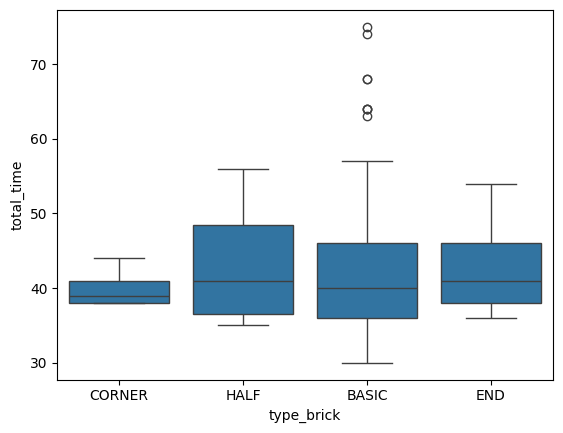

In [12]:
sns.boxplot(x='type_brick', y="total_time", data=df)

<Axes: xlabel='type_brick', ylabel='total_time_sim'>

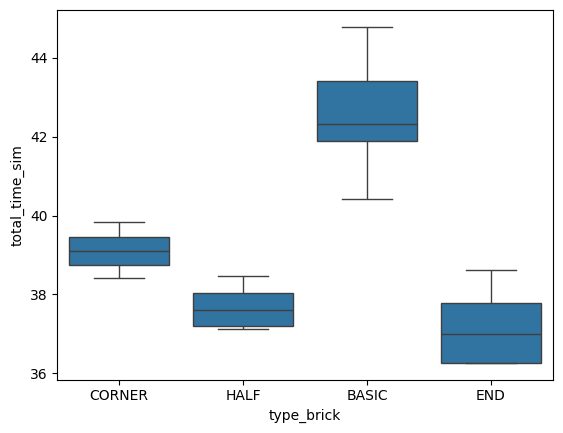

In [13]:
sns.boxplot(x='type_brick', y="total_time_sim", data=df)

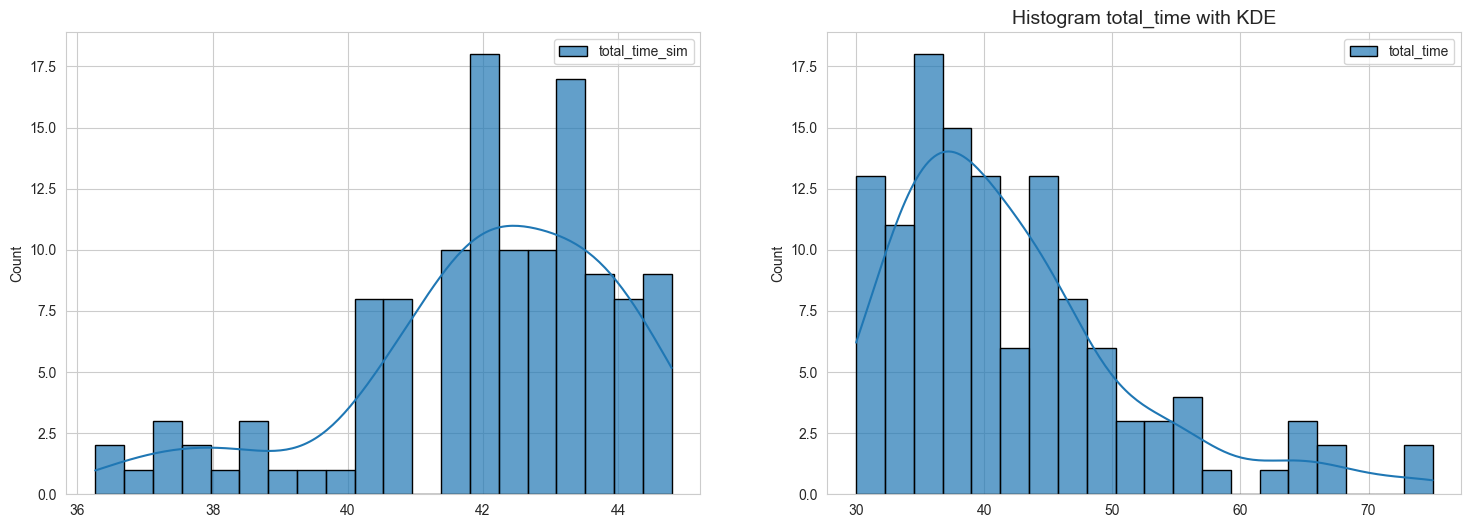

In [14]:
# Histogram with KDE (Kernel Density Estimation)

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# Generate random data
data = np.random.normal(loc=0, scale=1, size=100)  # Normally distributed data

# Create the plot
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))
# Add titles and labels
sns.histplot(df[['total_time']], kde=True, bins=20, color="skyblue", label='real total_time', edgecolor="black", alpha=0.7, ax=axs[1])
sns.histplot(df[['total_time_sim']], kde=True, bins=20, label='real total_time', edgecolor="black", alpha=0.7, ax=axs[0])

plt.title("Histogram total_time with KDE", fontsize=14)
# Show the plot
plt.show()

### Generate polar grid inside working range

In [31]:
def generate_grid_between_spheres(center, r_inner, r_outer, spacing):
    """
    Generate grid points between two concentric spheres.

    Parameters:
        center (tuple): (x, y, z)
        r_inner (float): inner radius
        r_outer (float): outer radius
        spacing (float): grid spacing

    Returns:
        numpy.ndarray: (N, 3) array of points
    """
    center = np.array(center)

    # Define bounding cube
    x = np.arange(center[0] - r_outer, center[0] + r_outer + spacing, spacing)
    y = np.arange(center[1] - r_outer, center[1] + r_outer + spacing, spacing)
    z = np.arange(center[2] - r_outer, center[2] + r_outer + spacing, spacing)

    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    # Flatten grid
    points = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T

    # Compute distances from center
    distances = np.linalg.norm(points - center, axis=1)

    # Mask points inside spherical shell
    mask = (distances >= r_inner) & (distances <= r_outer)

    return points[mask]

In [39]:
points = generate_grid_between_spheres(
    center=(2450, 2250, 1000),
    r_inner=range_min,
    r_outer=range_max,
    spacing=grid_simulation
)

print("Number of grid points:", len(points))
print(points[:5])

Number of grid points: 27425
[[-1254  1146   496]
 [-1254  1146   696]
 [-1254  1146   896]
 [-1254  1146  1096]
 [-1254  1146  1296]]


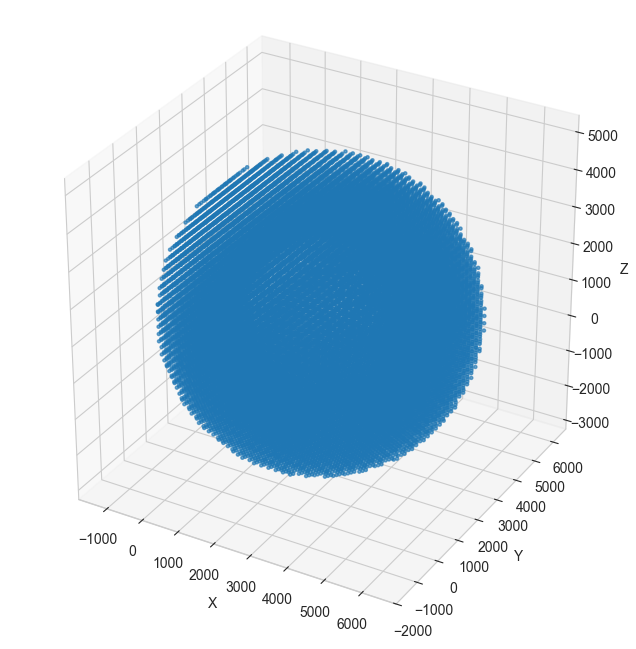

In [40]:
# --- Plot ---
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.set_box_aspect([1,1,1])  # equal aspect ratio
plt.show()

<h2>Save Dataset</h2>
<p>
Correspondingly, Pandas enables us to save the dataset to csv. By using the <code>dataframe.to_csv()</code> method, you can add the file path and name along with quotation marks in the brackets.
</p>
<p>
For example, if you would save the dataframe <b>df</b> as <b>automobile.csv</b> to your local machine, you may use the syntax below, where <code>index = False</code> means the row names will not be written.
</p>


In [15]:
df.to_csv("../../data/sim/model_data.csv", index=False)

We can also read and save other file formats. We can use similar functions like **`pd.read_csv()`** and **`df.to_csv()`** for other data formats. The functions are listed in the following table:


#### Author/Date/Organization

Vjaceslav Usmanov, CTU in Prague

###### Change Log


|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2026-01-20 | 1.1 | Vjaceslav Usmanov| added DM_02_Model_Parameters.ipynb |
| 2026-02-12 | 1.2 | Vjaceslav Usmanov| changed DM_02_Model_Parameters.ipynb |